<a href="https://colab.research.google.com/github/Priyansh-Mandkaria/hough_transform/blob/main/updated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install and import

In [45]:
!pip -q install opencv-python-headless==4.10.0.84 numpy matplotlib moviepy yt-dlp gdown tqdm

import os, glob, math, shutil, subprocess
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from tqdm import tqdm

In [46]:
# Only if needed
!apt -yq install ffmpeg
!pip -q install -U yt-dlp


Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# Step 2: Get sample images/videos

In [47]:
from google.colab import files
import os, shutil

def upload_local_safe(dest_name=None):
    from google.colab import files
    up = files.upload()
    if not up:
        raise ValueError("No file uploaded")

    # Get the first filename - handle all possible formats
    keys = list(up.keys())
    original_filename = keys[0]

    # Handle case where original_filename might be a list
    if isinstance(original_filename, list):
        original_filename = original_filename[0]

    # Convert to string to be absolutely sure
    original_filename = str(original_filename)

    # Use original name if no dest_name specified
    if dest_name is None:
        dest_name = original_filename

    # Handle case where dest_name might also be a list
    if isinstance(dest_name, list):
        dest_name = dest_name[0]

    # Convert to string
    dest_name = str(dest_name)

    print(f"Saving uploaded file as: {dest_name}")

    with open(dest_name, "wb") as f:
        f.write(up[original_filename])

    return dest_name



def mount_and_copy(drive_rel_path):
    drive.mount('/content/drive')
    src = os.path.join('/content/drive/MyDrive', drive_rel_path)
    if not os.path.exists(src): raise FileNotFoundError(src)
    dst = os.path.basename(src); shutil.copy(src, dst); return dst

def download_from_url(url, out_dir="inputs"):
    import urllib.request
    os.makedirs(out_dir, exist_ok=True)
    out = os.path.join(out_dir, os.path.basename(url) or "input.bin")
    urllib.request.urlretrieve(url, out)
    return out

def download_from_youtube(yt_url, out_dir="inputs"):
    os.makedirs(out_dir, exist_ok=True)
    cmd = ["yt-dlp","-f","bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4/best","-o",f"{out_dir}/%(title)s.%(ext)s", yt_url]
    subprocess.check_call(cmd)
    vids = sorted(glob.glob(f"{out_dir}/*.mp4"))
    if not vids: raise RuntimeError("No MP4 downloaded.")
    return vids

def get_input(mode="local_upload", value=None):
    # mode in {"local_upload","image_upload","drive_path","file_url","youtube_url"}
    if mode == "local_upload": return upload_local_safe()  # ← Remove hardcoded name
    if mode == "image_upload": return upload_local_safe()  # ← Remove hardcoded name
    if mode == "drive_path":   return mount_and_copy(value)
    if mode == "file_url":     return download_from_url(value)
    if mode == "youtube_url":  return download_from_youtube(value)
    raise ValueError(f"Unknown mode: {mode}")




# Step 3: Build the Canny + Hough pipeline

In [48]:
def to_gray(bgr): return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
def gaussian_blur(gray, k=5): return cv2.GaussianBlur(gray, (k, k), 0)
def canny_edges(blur, low=80, high=200): return cv2.Canny(blur, low, high)  # tune per scene

def default_roi(shape):
    h, w = shape[:2]
    return np.array([
        [int(0.10*w), h],
        [int(0.45*w), int(0.60*h)],
        [int(0.55*w), int(0.60*h)],
        [int(0.90*w), h],
    ], dtype=np.int32)

def roi_mask(binary, polygon):
    mask = np.zeros_like(binary)
    cv2.fillPoly(mask, [polygon.astype(np.int32)], 255)
    return cv2.bitwise_and(binary, mask)

def hough_segments(edges, rho=1, theta=np.pi/180, thr=20, min_len=20, max_gap=180):
    lines = cv2.HoughLinesP(edges, rho, theta, thr, minLineLength=min_len, maxLineGap=max_gap)
    return lines if lines is not None else np.array([])


# Step 4: Aggregate left/right lines and shade lane

In [49]:
def separate_and_fit(lines, shape, y_top_ratio=0.60):
    h, w = shape[:2]
    y1 = h; y2 = int(h*y_top_ratio)
    left, right = [], []
    for l in lines:
        for x1,y1l,x2,y2l in l:
            if x1==x2: continue
            m = (y2l-y1l)/(x2-x1)
            if abs(m) < 0.3: continue
            c = y1l - m*x1
            (left if m<0 else right).append((m,c))
    lf = np.mean(left, axis=0) if len(left) else None
    rf = np.mean(right,axis=0) if len(right) else None
    def ex(mc):
        if mc is None: return None
        m,c = mc; x1e = int((y1-c)/m); x2e = int((y2-c)/m)
        return (x1e,y1,x2e,y2)
    return lf, rf, ex(lf), ex(rf)

def draw_lane(bgr, left_pts, right_pts, alpha=0.35):
    overlay = bgr.copy()
    if left_pts is not None:
        x1,y1,x2,y2 = left_pts
        cv2.line(overlay,(x1,y1),(x2,y2),(255,100,0),10)  # left side
    if right_pts is not None:
        x1,y1,x2,y2 = right_pts
        cv2.line(overlay,(x1,y1),(x2,y2),(50,200,255),10) # right side
    if left_pts is not None and right_pts is not None:
        lx1,ly1,lx2,ly2 = left_pts
        rx1,ry1,rx2,ry2 = right_pts
        poly = np.array([[lx1,ly1],[lx2,ly2],[rx2,ry2],[rx1,ry1]], dtype=np.int32)
        cv2.fillPoly(overlay, [poly], (0,255,0))
        bgr = cv2.addWeighted(overlay, alpha, bgr, 1-alpha, 0)
    return bgr


# Step 5: Compute lane-center and LDW text

In [70]:
def lane_center_offset(shape, left_fit, right_fit):
    h, w = shape[:2]; y = h
    if left_fit is None or right_fit is None: return None, None, None
    lm, lc = left_fit; rm, rc = right_fit
    xl = (y - lc)/lm; xr = (y - rc)/rm
    x_center = 0.5*(xl + xr); cam_center = w/2.0
    offset_px = cam_center - x_center
    m_per_px = 3.7/abs(xr-xl) if abs(xr-xl)>1 else None
    offset_m = offset_px * m_per_px if m_per_px is not None else None
    return x_center, offset_px, offset_m

def process_frame_bgr(bgr,
                      canny_low=30, canny_high=100,
                      blur_k=3, hthr=10, hmin=10, hgap=180,
                      roi=None):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_k, blur_k), 0)
    edges = cv2.Canny(blur, canny_low, canny_high)
    roi = default_roi(bgr.shape) if roi is None else roi
    masked = roi_mask(edges, roi)
    lines = hough_segments(masked, rho=1, theta=np.pi/180, thr=hthr, min_len=hmin, max_gap=hgap)
    lfit, rfit, lpts, rpts = separate_and_fit(lines, bgr.shape)
    out = draw_lane(bgr.copy(), lpts, rpts, alpha=0.35)
    _, off_px, off_m = lane_center_offset(bgr.shape, lfit, rfit)
    warn = "Lane hold"
    if off_px is not None:
        th = bgr.shape[1]*0.05
        if off_px >  th: warn = "Drift: LEFT"
        if off_px < -th: warn = "Drift: RIGHT"
        cv2.putText(out, f"Offset: {off_px:.1f}px", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (30,255,30), 2)
        if off_m is not None:
            cv2.putText(out, f"Offset: {off_m:.2f} m", (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (30,255,30), 2)
    cv2.putText(out, warn, (20,120), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,200,255), 2)
    return out


# Step 6: Run on your images

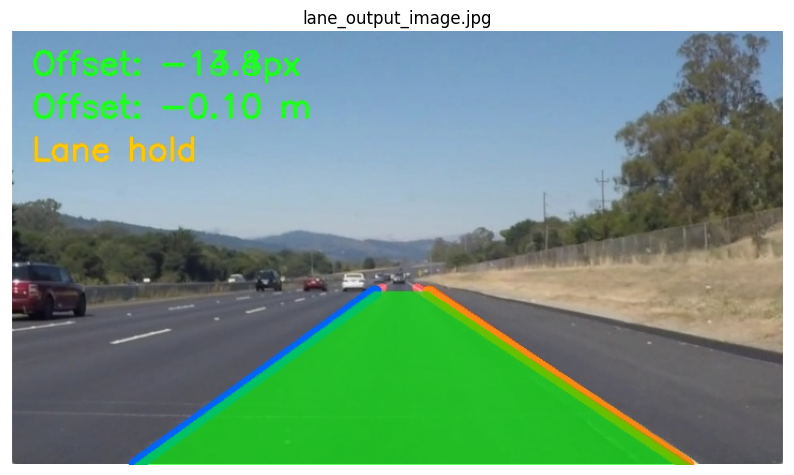

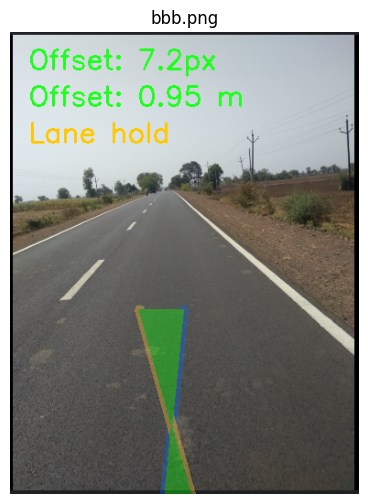

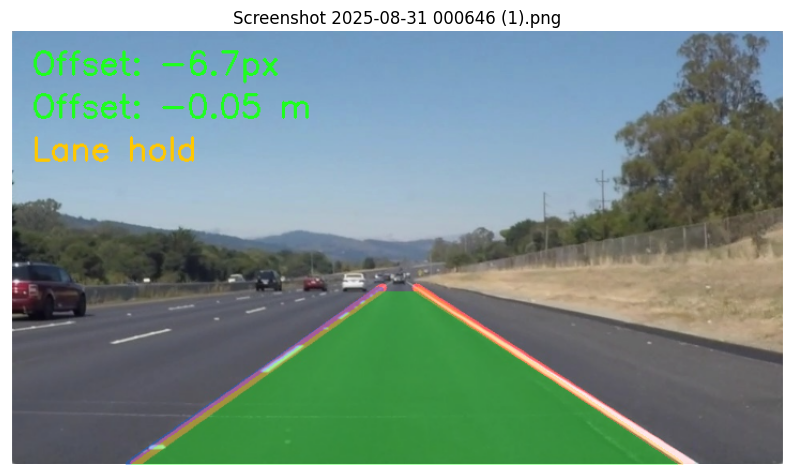

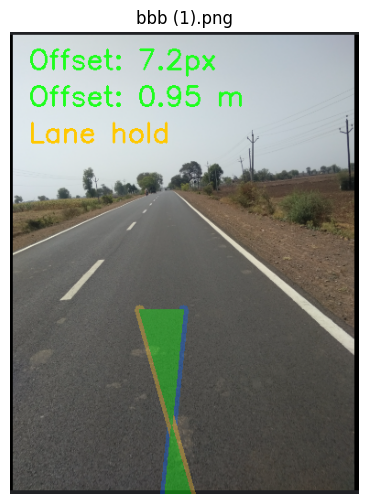

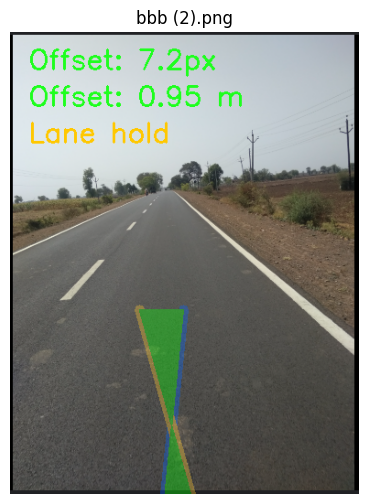

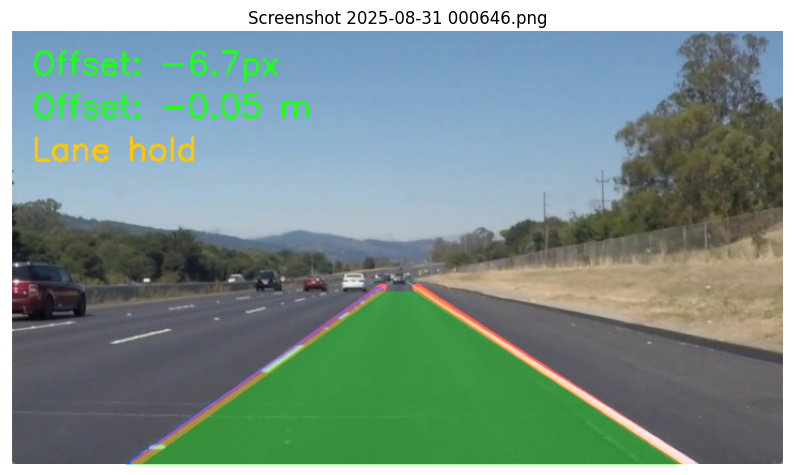

In [71]:
# Example: use local_upload or drive_path or file_url to bring images in
# img_path = get_input("local_upload")  # choose a file
# Or process all images in a folder you populated:
img_paths = [p for p in glob.glob("*.jpg")+glob.glob("*.png")]
def is_image_file(path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    return path.lower().endswith(image_extensions)


for p in img_paths:
    bgr = cv2.imread(p)
    out = process_frame_bgr(bgr)
    plt.figure(figsize=(10,6)); plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(p)); plt.axis('off'); plt.show()


# Step 7: Run on your videos

Saving Screenshot 2025-08-31 000646.png to Screenshot 2025-08-31 000646 (2).png
Saving uploaded file as: Screenshot 2025-08-31 000646 (2).png
Input: Screenshot 2025-08-31 000646 (2).png
Processing as IMAGE...


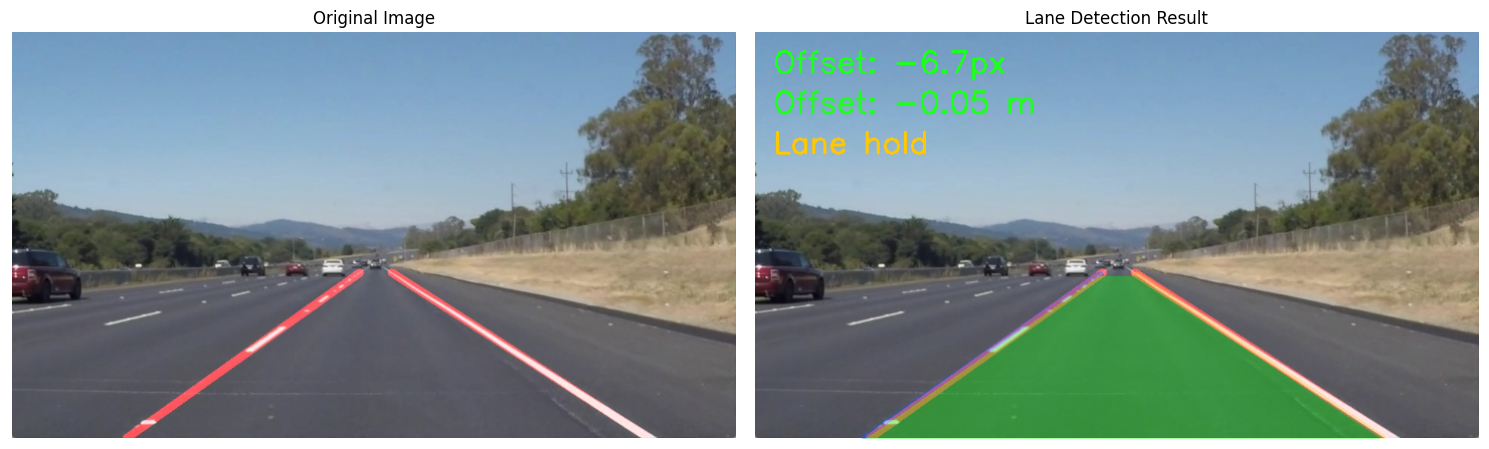

Saved processed image: lane_output_image.jpg


In [72]:
# Step 7: Run on both images AND videos
# Pick exactly one:
# mode, value = "local_upload", None      # Video upload
# mode, value = "image_upload", None      # Image upload
# mode, value = "drive_path", "path/in/MyDrive/road.mp4"
# mode, value = "file_url", "<YOUR_DIRECT_FILE_URL>"
# mode, value = "youtube_url", "<YOUR_YOUTUBE_URL>"

mode, value = "local_upload", None  # change as needed
src_path = get_input(mode, value)
print("Input:", src_path)

# Ensure a single string filename (not list/tuple)
if isinstance(src_path, (list, tuple)):
    src_path = src_path[0]
src_path = str(src_path)

# NEW: Check if input is image or video
if is_image_file(src_path):
    print("Processing as IMAGE...")
    # IMAGE PROCESSING PATH
    img = cv2.imread(src_path)
    if img is None:
        raise ValueError(f"Could not read image: {src_path}")

    # Apply your lane detection to the image
    processed_img = process_frame_bgr(img)

    # Display results side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Lane Detection Result')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Save processed image
    out_path = "lane_output_image.jpg"
    cv2.imwrite(out_path, processed_img)
    print("Saved processed image:", out_path)

else:
    print("Processing as VIDEO...")
    # YOUR EXISTING VIDEO PROCESSING PATH (unchanged)
    clip = VideoFileClip(src_path)

    def _proc(rgb):
        bgr  = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        outb = process_frame_bgr(bgr)
        return cv2.cvtColor(outb, cv2.COLOR_BGR2RGB)

    out_path = "lane_output.mp4"
    clip.fl_image(_proc).write_videofile(out_path, audio=False)
    print("Saved:", out_path)
